In [153]:
import pyspark
from pyspark.sql import SparkSession
import os
from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as func
from pyspark.sql.functions import pandas_udf, PandasUDFType, udf
from PIL import Image, ImageDraw, ImageFont
import io
import math
import pandas as pd

In [5]:
pravega_jars = [
    'pravega-connectors-spark-0.4.0-SNAPSHOT.jar', 
    'pravega-keycloak-credentials-0.4.0-2030.d99411b-0.0.1-020.26736d2-shadow.jar']
spark_jars_conf = ','.join([os.path.join('/usr/local/share/java', j) for j in pravega_jars])
spark = (SparkSession
             .builder
             #.appName('test1')
             .config('spark.jars', spark_jars_conf)
             .getOrCreate()
             )
spark.conf.set('spark.sql.shuffle.partitions', '1')
spark.conf.set('spark.sql.execution.arrow.enabled', 'true')

In [82]:
#controller = 'tcp://nautilus-pravega-controller.nautilus-pravega.svc.cluster.local:9090'
controller = 'tcp://127.0.0.1:9090'
scope = 'examples'
# Read a batch dataframe.
df0 = (spark
      .read
      .format("pravega")
      .option("controller", controller)
      .option("scope", scope)
      .option("stream", "video")
      .option("encoding", "chunked_v1")
      .load()
      )

In [89]:
df1 = df0.limit(1000).cache()

In [90]:
df1.show()

+--------------------+--------+------+----------+------+
|               event|   scope|stream|segment_id|offset|
+--------------------+--------+------+----------+------+
|[7B 22 74 69 6D 6...|examples| video|         0|     0|
|[7B 22 74 69 6D 6...|examples| video|         0| 14216|
|[7B 22 74 69 6D 6...|examples| video|         0| 28432|
|[7B 22 74 69 6D 6...|examples| video|         0| 42648|
|[7B 22 74 69 6D 6...|examples| video|         0| 56864|
|[7B 22 74 69 6D 6...|examples| video|         0| 71080|
|[7B 22 74 69 6D 6...|examples| video|         0| 85296|
|[7B 22 74 69 6D 6...|examples| video|         0| 99512|
|[7B 22 74 69 6D 6...|examples| video|         0|113728|
|[7B 22 74 69 6D 6...|examples| video|         0|127944|
|[7B 22 74 69 6D 6...|examples| video|         0|142160|
|[7B 22 74 69 6D 6...|examples| video|         0|156377|
|[7B 22 74 69 6D 6...|examples| video|         0|170594|
|[7B 22 74 69 6D 6...|examples| video|         0|184811|
|[7B 22 74 69 6D 6...|examples|

In [91]:
# def f(row):
#     filename = '/tmp/file-%d' % (row.offset,)
#     with open(filename, 'wb') as output:
#         output.write(row.event)
# df.foreach(f)

In [92]:
schema='timestamp timestamp, frame_number int, camera int, ssrc int, data binary'
df = df1
df = df.withColumnRenamed('event', 'raw_event')
df = df.select('*', decode('raw_event', 'UTF-8').alias('event_string'))
df = df.select('*', from_json('event_string', schema=schema).alias('event'))
df = df.select('*', 'event.*')
df = df.select('*', length('data'))
df = df.drop('raw_event', 'event_string', 'event')
df = df.withWatermark('timestamp', '1 second')
df2 = df

In [106]:
pdf2 = df2.toPandas()
pdf2

,scope,stream,segment_id,offset,timestamp,frame_number,camera,ssrc,data,length(data)
0,examples,video,0,0,2019-05-25 22:56:56.054,0,2,778568704,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,10570
1,examples,video,0,14216,2019-05-25 22:56:57.054,1,2,778568704,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,10570
2,examples,video,0,28432,2019-05-25 22:56:58.054,2,2,778568704,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,10570
3,examples,video,0,42648,2019-05-25 22:56:59.054,3,2,778568704,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,10570
4,examples,video,0,56864,2019-05-25 22:57:00.054,4,2,778568704,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,10570
5,examples,video,0,71080,2019-05-25 22:57:01.054,5,2,778568704,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,10570
6,examples,video,0,85296,2019-05-25 22:57:02.054,6,2,778568704,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,10570
7,examples,video,0,99512,2019-05-25 22:57:03.054,7,2,778568704,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,10570
8,examples,video,0,113728,2019-05-25 22:57:04.054,8,2,778568704,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,10570
9,examples,video,0,127944,2019-05-25 22:57:05.054,9,2,778568704,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,10570


In [107]:
pdf22 = pdf2[pdf2.frame_number == 0]
pdf22

,scope,stream,segment_id,offset,timestamp,frame_number,camera,ssrc,data,length(data)
0,examples,video,0,0,2019-05-25 22:56:56.054,0,2,778568704,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,10570
33,examples,video,0,469151,2019-05-25 22:56:56.055,0,3,778568704,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,10570
106,examples,video,0,1506982,2019-05-25 22:56:56.053,0,1,778568704,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,10570
219,examples,video,0,3113493,2019-05-25 22:56:56.052,0,0,778568704,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,10570


In [158]:
def combine_images_into_grid(df):
    # Get first image to determine height, width.
    row0 = df.iloc[0]
    image0_png_bytes = row0['data']    
    image0_pil = Image.open(io.BytesIO(image0_png_bytes))
    num_cameras = pdf22.camera.max() + 1
    # Determine number of images per row and column.
    grid_count = math.ceil(math.sqrt(num_cameras))
    image_width = image0_pil.width + 1  # add 1 for margin between images
    image_height = image0_pil.height + 1 # add 1 for margin between images
    # Create blank output image, white background.
    out_pil = Image.new('RGB', (image_width * grid_count - 1, image_height * grid_count - 1), (255,255,255))    
    def add_image(r):
        in_pil = Image.open(io.BytesIO(r['data']))
        x = (r['camera'] % grid_count) * image_width
        y = (r['camera'] // grid_count) * image_width
        out_pil.paste(in_pil, (x, y))    
    df.apply(add_image, axis=1)
    new_row = row0[['timestamp', 'frame_number']]
    new_row['data'] = out_pil
    return pd.DataFrame([new_row])

In [162]:
pdf22.empty

False

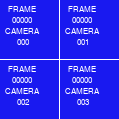

In [160]:
combine_images_into_grid(pdf22).iloc[0]['data']

In [118]:
pdf23 = pdf22.set_index(['camera'])

In [119]:
image0_png_bytes = pdf23.loc[0]['data']

In [120]:
image0_pil = Image.open(io.BytesIO(image0_png_bytes))

In [121]:
image0_pil.width, image0_pil.height

(59, 59)

In [113]:
num_cameras = pdf22.camera.max() + 1
grid_count = math.ceil(math.sqrt(num_cameras))
num_cameras, grid_count

(4, 2)

In [114]:
image_width = image0_pil.width + 1
image_height = image0_pil.height + 1

In [125]:
out_pil = Image.new('RGB', (image_width * grid_count - 1, image_height * grid_count - 1), (255,255,255))
out_pil.width, out_pil.height

(119, 119)

In [126]:
image1_pil = Image.open(io.BytesIO(pdf23.loc[1]['data']))
image2_pil = Image.open(io.BytesIO(pdf23.loc[2]['data']))
image3_pil = Image.open(io.BytesIO(pdf23.loc[3]['data']))

In [127]:
out_pil.paste(image0_pil, (0, 0))
out_pil.paste(image1_pil, (image_width * 1, 0))
out_pil.paste(image2_pil, (0, image_height * 1))
out_pil.paste(image3_pil, (image_width * 1, image_height * 1))

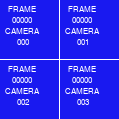

In [128]:
out_pil

In [20]:


grp = df.groupby(
        # window('timestamp', '1 second'),
        'frame_number',
)

@pandas_udf(returnType='frame_number int, data binary', functionType=PandasUDFType.GROUPED_MAP)
def combine_thumbnails(df):
    """Input is a Pandas dataframe with 1 row per camera and frame.
    Output should be a Pandas dataframe with 1 row per frame."""
    print(f'combine_thumbnails: s={df}')
    df.info(verbose=True)

    return df[['frame_number', 'data']]

df = grp.apply(combine_thumbnails)
df.show()

+------------+--------------------+
|frame_number|                data|
+------------+--------------------+
|           0|[89 50 4E 47 0D 0...|
|           1|[89 50 4E 47 0D 0...|
|           2|[89 50 4E 47 0D 0...|
|           3|[89 50 4E 47 0D 0...|
|           4|[89 50 4E 47 0D 0...|
|           5|[89 50 4E 47 0D 0...|
|           6|[89 50 4E 47 0D 0...|
|           7|[89 50 4E 47 0D 0...|
|           8|[89 50 4E 47 0D 0...|
|           9|[89 50 4E 47 0D 0...|
+------------+--------------------+



In [21]:
pdf = df.toPandas()

/opt/conda/lib/python3.7/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


In [23]:
pdf

,frame_number,data
0,0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
1,1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
2,2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
3,3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
4,4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
5,5,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
6,6,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
7,7,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
8,8,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
9,9,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
